# INTRODUCCION

Para desarrollar este laboratorio, usaremos el set de datos Credit Card Fraut Detection de la web de Kaggle. Son 66 MB que al descomprimir ocuparán 150MB. Usaremos el archivo creditcard.csv. Este dataset consta de 285.000 filas con 31 columnas (features). Como la información es privada, no sabemos realmente que significan los features y están nombradas como V1, V2, V3, etc. excepto por las columnas Time y Amount (el importe de la transacción). Y nuestras clases son 0 y 1 correspondiendo con “transacción Normal” ó “Hubo Fraude”.

En este ejercicio compararemos una Regresión Logística contra Random Forrest.

NOTA : dado el tamaño del dataset, el proceso de carga puede ser lento.

## Importar librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
#col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
#sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

## Cargamos Datos

En este caso subiremos podrás ubicar el archivo comprimido en la dirección indicada. Debes dejarlo local para leerlo ejecutando lo siguiente:

In [ ]:
# Descargar desde https://www.kaggle.com/mlg-ulb/creditcardfraud/data

from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
df = pd.read_csv(name, sep=",")
#df = pd.read_csv("creditcard.csv")
df.head(n=5) 

Saving creditcard.csv to creditcard.csv


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.shape

(284807, 31)

## Vemos Desbalanceo

**Revisa cuantas observaciones corresponden a cada clase.**

In [ ]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
normal_df = df[df.Class == 0] #registros normales
fraud_df = df[df.Class == 1] #casos de fraude

## Creamos Dataset

In [ ]:
y = df['Class']
X = df.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [ ]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

## Ejecutamos Modelo con LogisticRegresion para poder Comparar

In [ ]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


### Veamos como responde en el test set

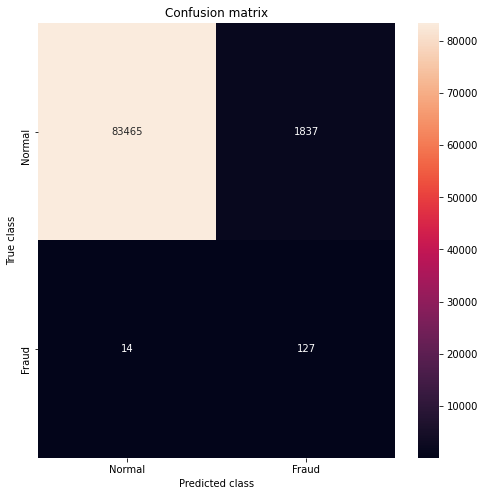

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85302
           1       0.06      0.90      0.12       141

    accuracy                           0.98     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.98      0.99     85443



In [ ]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# **ANALIZAR**

¿Cuál es el nivel de exactitud de este modelo?

¿Qué otras métricas puedes comentar? ¿Qué dicen?

# Probamos con Random Forest

## ATENCION: Este modelo toma algo más de tiempo en entrenar

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo con 100 arboles
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,verbose=2,
                               max_features = 'sqrt')
# entrenar!
model.fit(X_train, y_train)

### Revisemos los resultados

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished


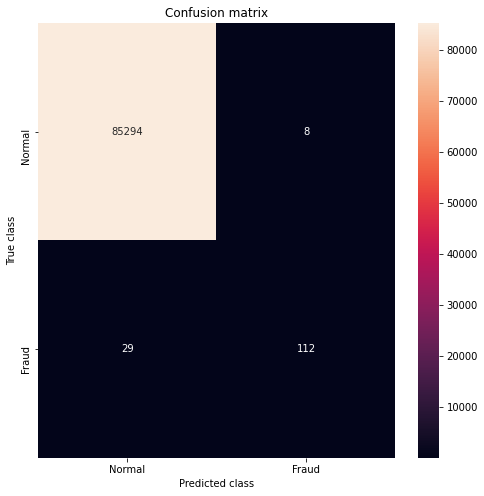

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85302
           1       0.93      0.79      0.86       141

    accuracy                           1.00     85443
   macro avg       0.97      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# **Analizar**

Lee las métricas anteriores, ¿qué puedes comentar de estas?

# Otro Bosque: Random Forest -más veloz-

In [ ]:
# otro modelo, variando hiperparámetros
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=2, max_depth=6,
                               oob_score=True, random_state=50)
# a entrenar
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=50, verbose=2,
                       warm_start=False)

## Veamos la Confusion Matrix con el conjunto de Test

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


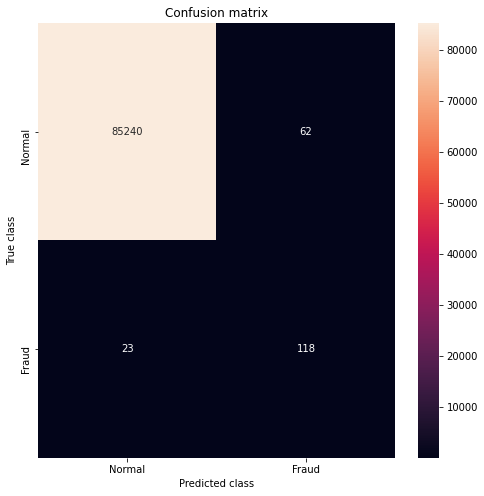

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85302
           1       0.66      0.84      0.74       141

    accuracy                           1.00     85443
   macro avg       0.83      0.92      0.87     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# **ANALIZAR**

En este modelo, ¿que reflejan las métricas?

# Comprobamos Resultados

## **Investiga**

¿Qué significa y para que sirve el "roc_auc_score"?

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, pred_y)

In [ ]:
print(roc_value)

0.9180763016207248


El valor de roc cuanto más cerca de 1, mejor. si fuera 0.5 daría igual que fuesen valores aleatorios y sería un mal modelo

# **CONCLUSIONES**

Reflexiona sobre este ejercicio.

¿Qué puedes comentar sobre Random Forrest?

Comparte tu análisis con el resto del curso.